# SW 02 Exercises Solutions

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose, STL

import os
import sys
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), '..', 'notebooks'))

from data import get_random_walk
from utils import get_figure

np.random.seed(42)

## Part 1: Generate 2-3 synthetic time series with known components and review how well components are extracted

MSE Scores:
- Time series 1:
  - STL Decomposition:
    - Trend MSE: 0.000
    - Seasonal MSE: 0.242
    - Residual MSE: 0.242
  - Classical Decomposition:
    - Trend MSE: 0.000
    - Seasonal MSE: 0.246
    - Residual MSE: 0.246
- Time series 2:
  - STL Decomposition:
    - Trend MSE: 22563389.277
    - Seasonal MSE: 0.708
    - Residual MSE: 0.632
  - Classical Decomposition:
    - Trend MSE: 10661473.730
    - Seasonal MSE: 0.727
    - Residual MSE: 0.659

For the first time series, both methods performed similarly well. However, the residuals seem to be off for the classical decomposition (mostly 0).

For the second time series, both methods really struggled with the trend component, likely due to its quadratic nature. The STL decomposition performed slightly better in terms of MSE for the trend component, but both methods had high errors.

For both time series, the classical decomposition failed to extract the trend over the entire period with NaN values at the beginning and end of the series.

In [12]:
def stl_decomposition(data, title, period):
  res = STL(data, period=period).fit()
  fig = res.plot()
  fig.axes[0].set_title("")
  fig.set_size_inches(12, 8)
  fig.suptitle(title, y=1)
  fig.tight_layout()
  return res

def classical_decomposition(data, title, period):
  res = seasonal_decompose(data, period=period)
  fig = res.plot()
  fig.set_size_inches(12, 8)
  fig.suptitle(title, y=1)
  fig.tight_layout()
  return res

def calculate_mse_scores(decomp_result, true_trend, true_seasonal, true_noise, method_name): 
    # handle NaN in trend values by masking them
    trend_mask = ~np.isnan(decomp_result.trend)
    trend_mse = mean_squared_error(true_trend[trend_mask], 
                                   decomp_result.trend[trend_mask])
    
    seasonal_mse = mean_squared_error(true_seasonal, decomp_result.seasonal)

    resid_mask = ~np.isnan(decomp_result.resid)
    noise_mse = mean_squared_error(true_noise[resid_mask], 
                                   decomp_result.resid[resid_mask])
    
    print(f"\n{method_name} MSE Scores:")
    print(f"  Trend MSE: {trend_mse:.3f}")
    print(f"  Seasonal MSE: {seasonal_mse:.3f}")
    print(f"  Residual MSE: {noise_mse:.3f}")
    
    return trend_mse, seasonal_mse, noise_mse

def plot_actual_components(data, true_trend, true_seasonal, true_noise, dates, title):
    fig, axes = plt.subplots(4, 1, figsize=(12, 8))
    
    # Original time series
    axes[0].plot(dates, data, color='steelblue', linewidth=1)
    axes[0].set_ylabel('Original')
    axes[0].grid(True, alpha=0.3)
    
    # True trend
    axes[1].plot(dates, true_trend, color='steelblue', linewidth=1)
    axes[1].set_ylabel('Trend')
    axes[1].grid(True, alpha=0.3)
    
    # True seasonal
    axes[2].plot(dates, true_seasonal, color='steelblue', linewidth=1)
    axes[2].set_ylabel('Seasonal')
    axes[2].grid(True, alpha=0.3)
    
    # True residual
    axes[3].scatter(dates, true_noise, color='steelblue', s=4, alpha=0.7)
    axes[3].set_ylabel('Resid')
    axes[3].grid(True, alpha=0.3)
    
    fig.suptitle(title, y=0.98)
    fig.tight_layout()
    
    return fig

In [13]:
n_points = 365 * 2  # 2 years of daily data
dates = pd.date_range('2025-01-01', periods=n_points, freq='D')

### TS 1

- Trend: Linear upward trend (0.02 units per day), starting at baseline of 10
- Seasonality: An annual cycle (amplitude 3)
- Noise: Moderate Gaussian noise ($\sigma=0.5$)

In [14]:
t = np.arange(n_points)
trend1 = 0.02 * t + 10
seasonal1 = 3 * np.sin(2 * np.pi * t / 365)
noise1 = np.random.normal(0, 0.5, n_points)
ts1 = trend1 + seasonal1 + noise1
data1 = pd.DataFrame(data=ts1, index=dates)

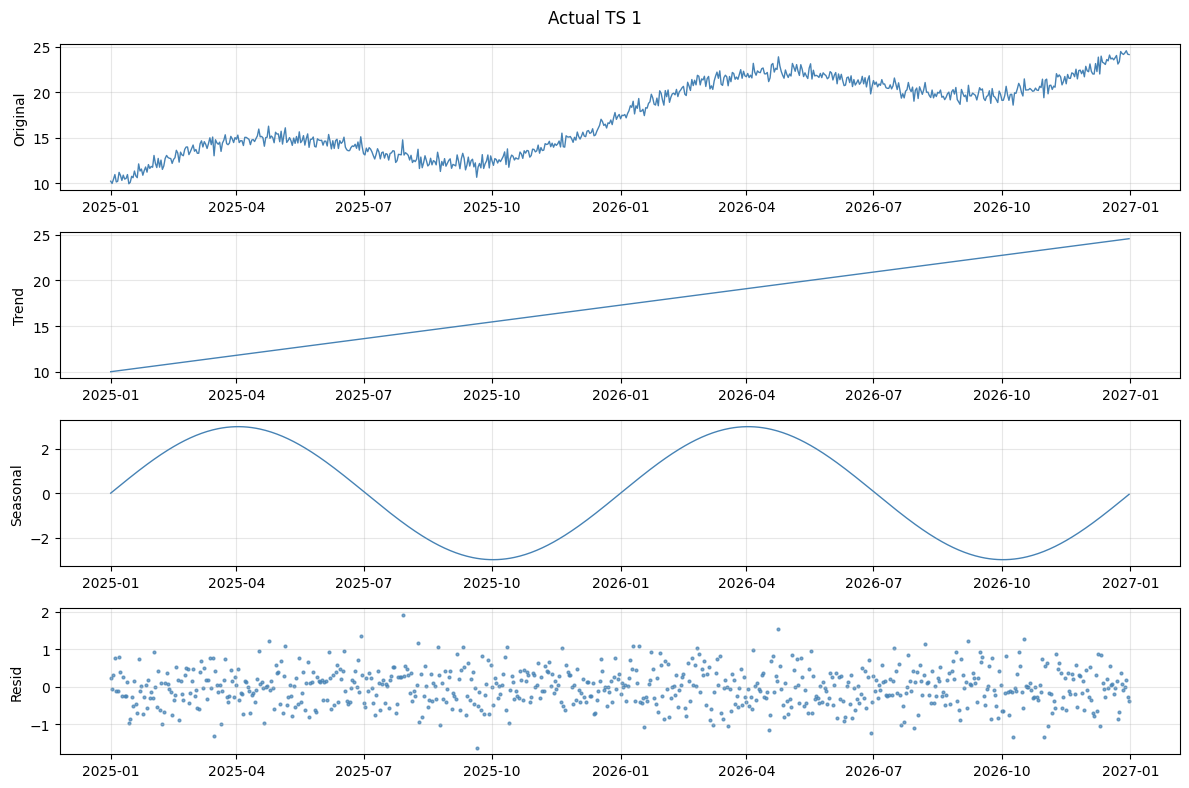

In [15]:
plot_actual_components(data1, trend1, seasonal1, noise1, dates, "Actual TS 1");

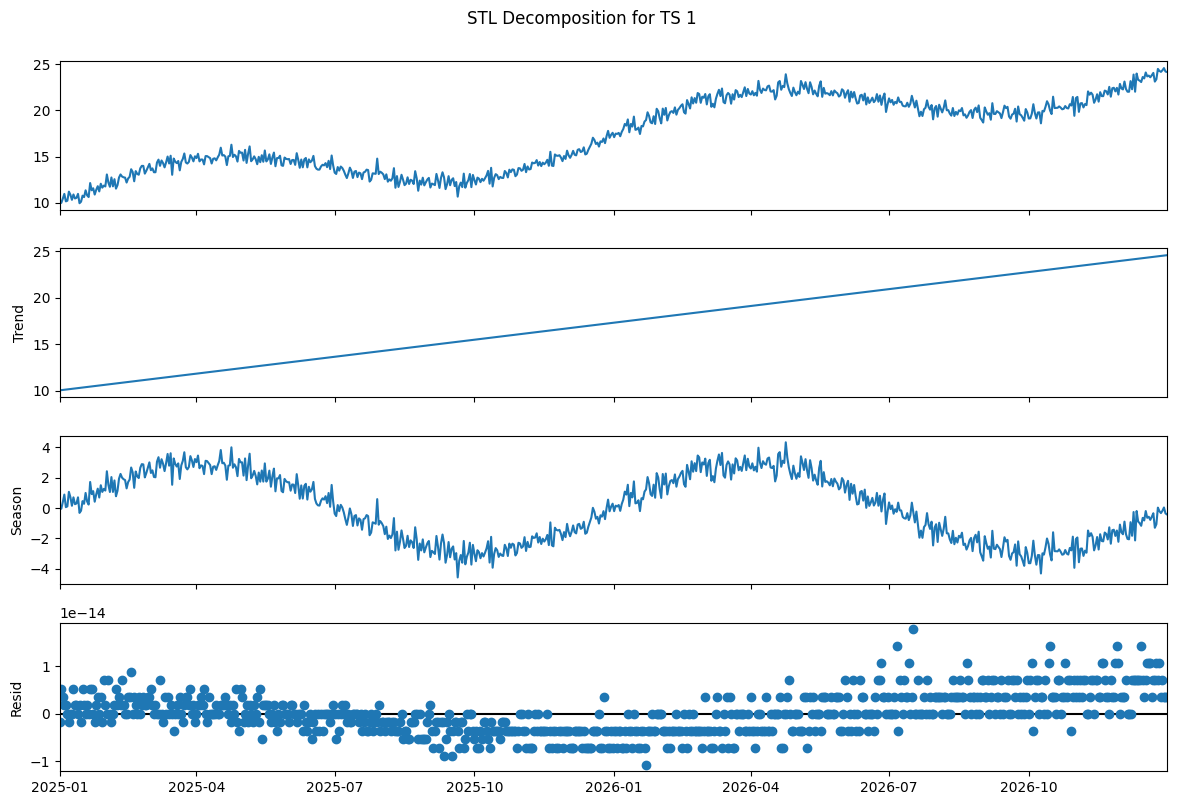

In [16]:
stl_decomp_1 = stl_decomposition(data1, "STL Decomposition for TS 1", period=365)

In [17]:
_ = calculate_mse_scores(stl_decomp_1, trend1, seasonal1, noise1, "STL TS1")


STL TS1 MSE Scores:
  Trend MSE: 0.000
  Seasonal MSE: 0.242
  Residual MSE: 0.242


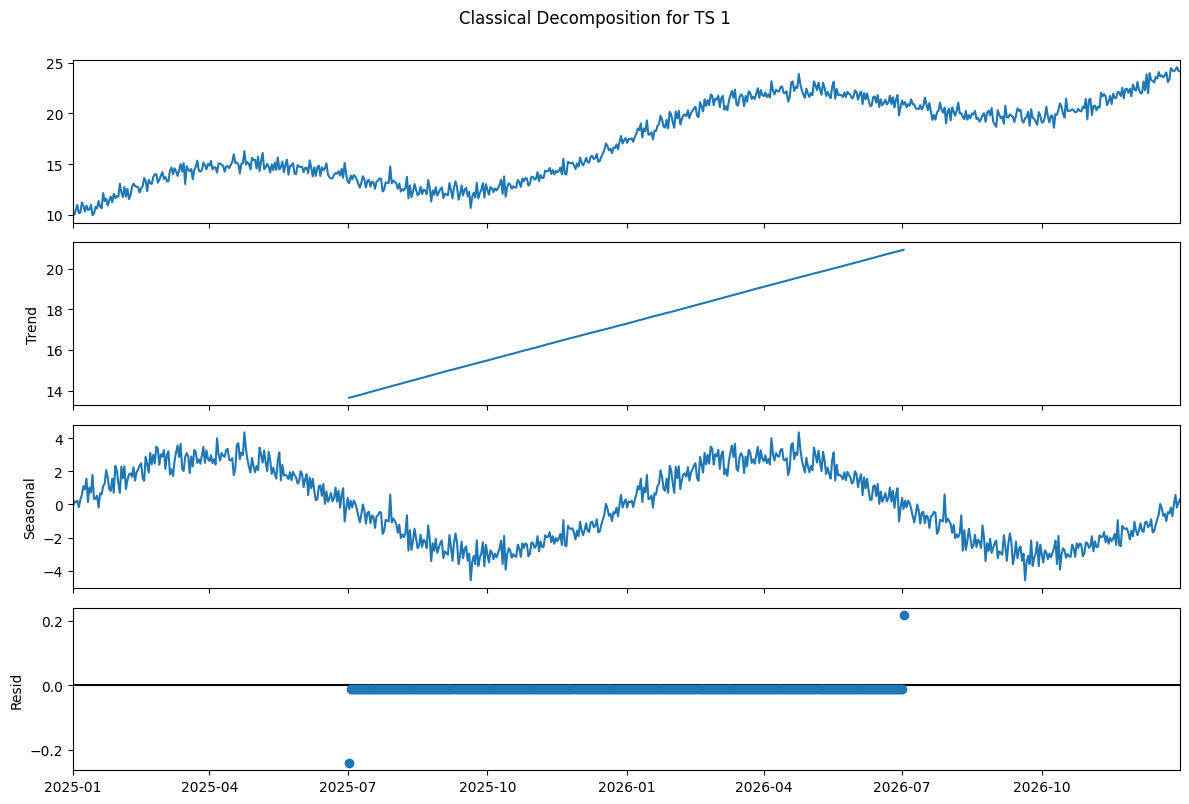

In [18]:
classical_decomp_1 = classical_decomposition(data1, "Classical Decomposition for TS 1", period=365)

In [19]:
_ = calculate_mse_scores(classical_decomp_1, trend1, seasonal1, noise1, "Classical TS1")


Classical TS1 MSE Scores:
  Trend MSE: 0.000
  Seasonal MSE: 0.246
  Residual MSE: 0.246


### TS 2

- Trend: Quadratic trend that increases, starting at baseline of 10
- Seasonality: Stronger yearly cycle (amplitude 5)
- Noise: Higher Gaussian noise ($\sigma=0.8$)

In [20]:
trend2 = 0.02 * t**2 + 10
seasonal2 = 5 * np.sin(2 * np.pi * t / 365)
noise2 = np.random.normal(0, 0.8, n_points)
ts2 = trend2 + seasonal2 + noise2
data2 = pd.DataFrame(data=ts1, index=dates)

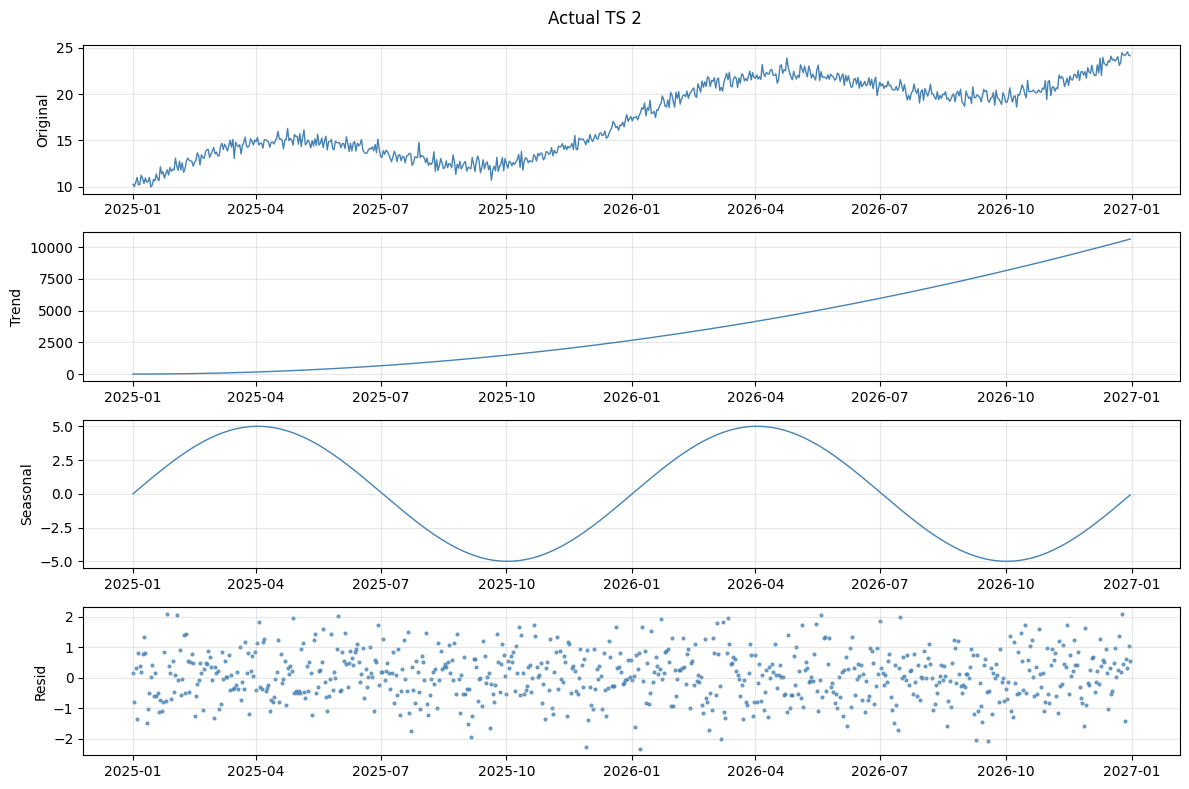

In [21]:
plot_actual_components(data2, trend2, seasonal2, noise2, dates, "Actual TS 2");

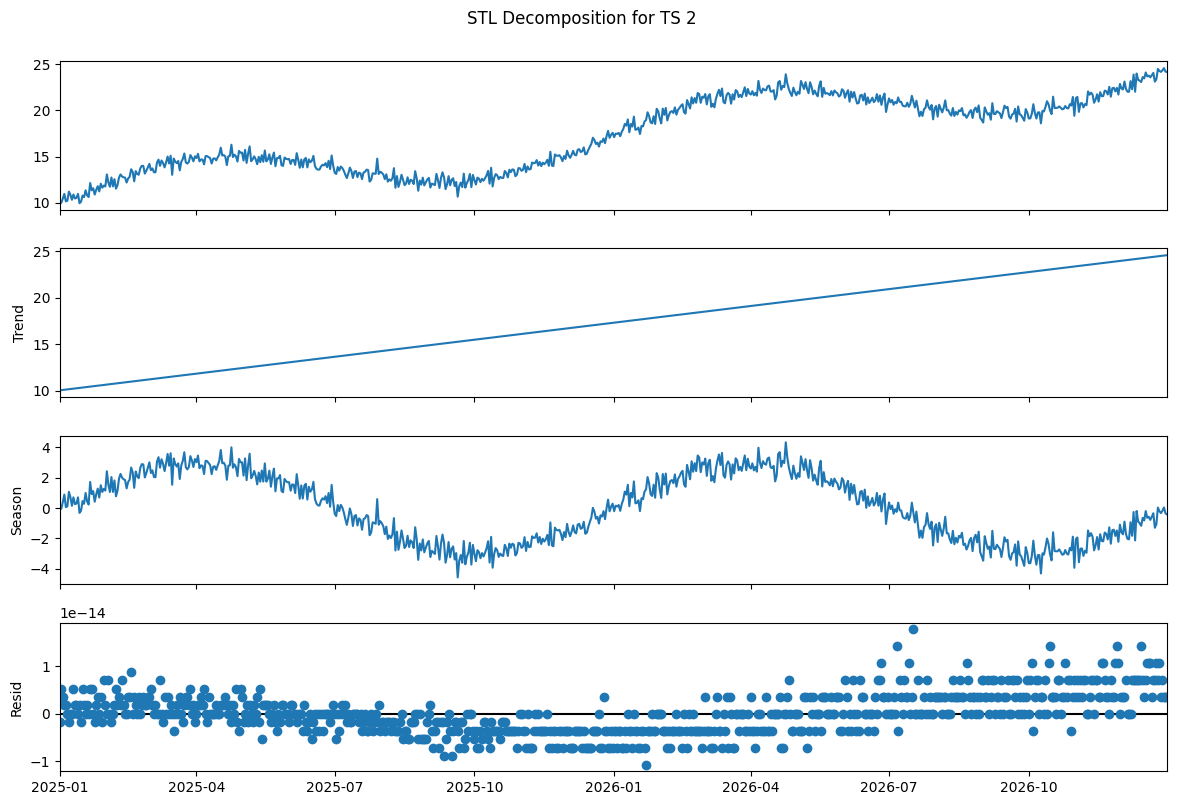

In [22]:
stl_decomp_2 = stl_decomposition(data2, "STL Decomposition for TS 2", period=365)

In [23]:
_ = calculate_mse_scores(stl_decomp_2, trend2, seasonal2, noise2, "STL TS2")


STL TS2 MSE Scores:
  Trend MSE: 22563389.277
  Seasonal MSE: 2.309
  Residual MSE: 0.632


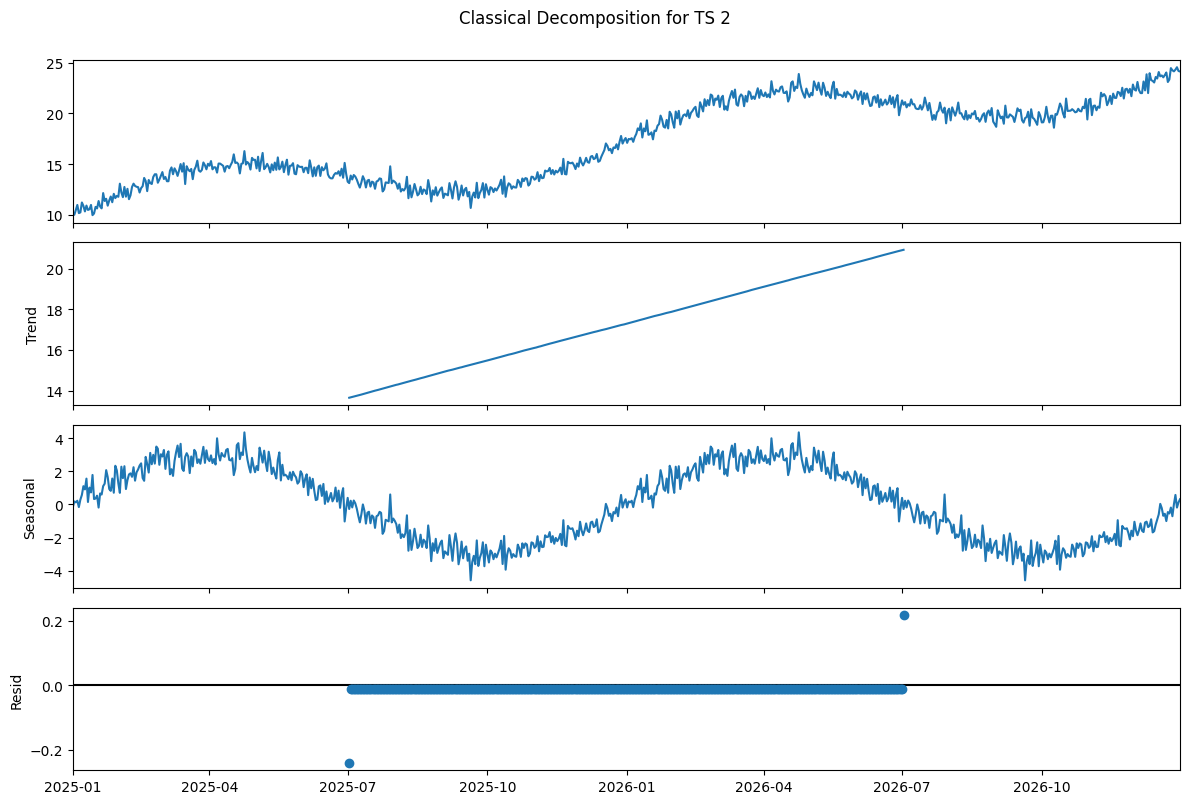

In [24]:
classical_decomp_2 = classical_decomposition(data2, "Classical Decomposition for TS 2", period=365)

In [25]:
_ = calculate_mse_scores(classical_decomp_2, trend2, seasonal2, noise2, "Classical TS2")


Classical TS2 MSE Scores:
  Trend MSE: 10661473.730
  Seasonal MSE: 2.283
  Residual MSE: 0.659


## Part 2: Generate and interpret ACF plots

### Regular Random walk

ACF decays very slowly. In a random walk, past values keep influencing future values for a long time, which is exactly what this slow decline shows.

In [26]:
n_steps = 100
variance = 1

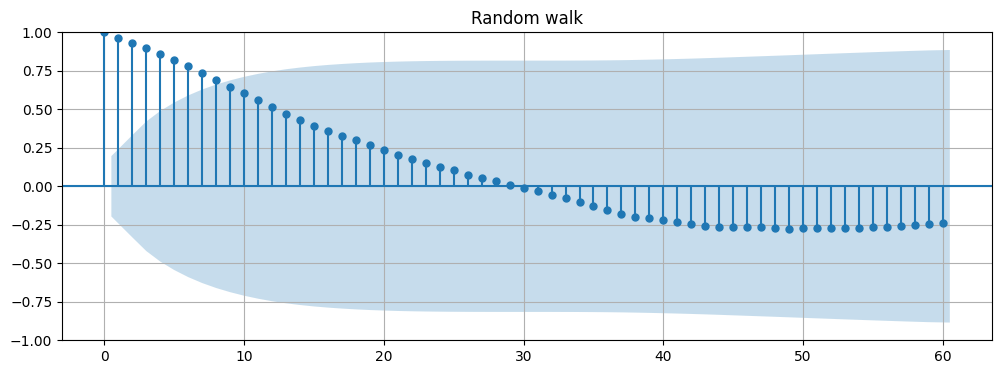

In [27]:
fig, [ax] = get_figure()
rw = get_random_walk(42, n_steps, variance)
sm.graphics.tsa.plot_acf(rw, lags=60, ax=ax)
ax.set_title("Random walk");

### Random walk with drift

This ACF plot looks nearly identical to the regular random walk. Adding drift doesn't change the autocorrelation structure, as the random walk nature still dominates the behavior.

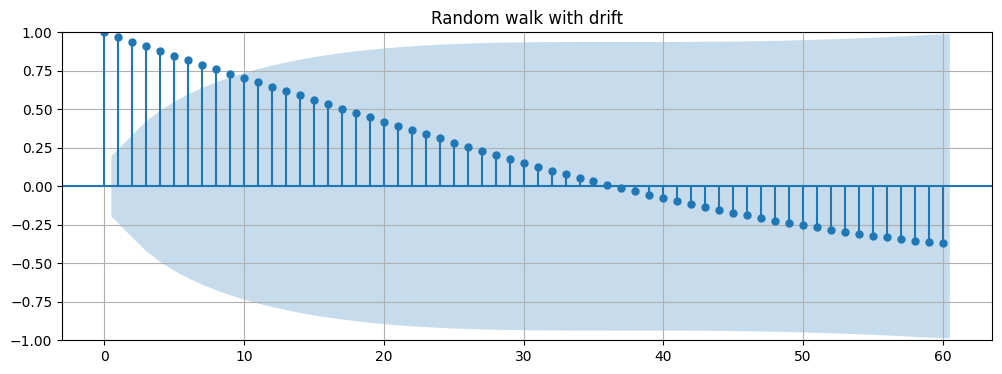

In [28]:
drift = 2

fig, [ax] = get_figure()
rw = get_random_walk(42, n_steps, variance, drift)
sm.graphics.tsa.plot_acf(rw, lags=60, ax=ax)
ax.set_title("Random walk with drift");

### Seasonal random walk

This ACF plot shows a completely different pattern. It shows regular waves that repeat every 20 lags (matching the seasonal period).
High positive correlations at lags 20, 40 and 60 (seasonal intervals), negative correlations in between.

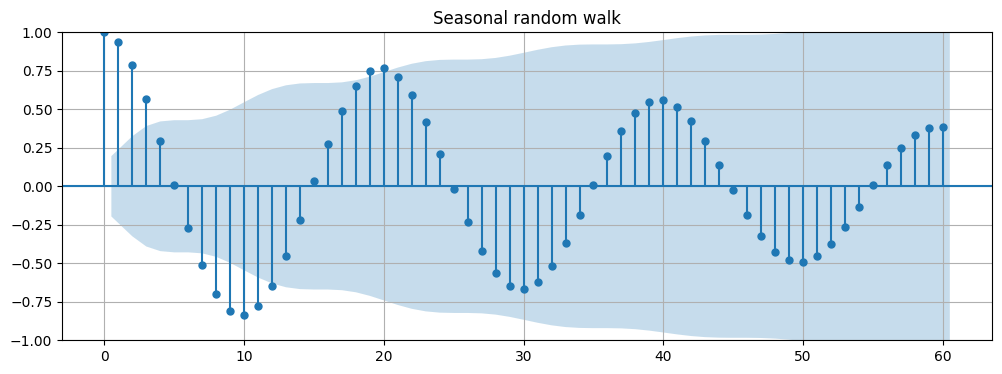

In [29]:
amplitude = 10
period = 20
samples = np.arange(n_steps)
seasonal = amplitude * np.sin(2 * np.pi * samples / period)

fig, [ax] = get_figure()
rw = get_random_walk(42, n_steps, variance, seasonal=seasonal)
sm.graphics.tsa.plot_acf(rw, lags=60, ax=ax)
ax.set_title("Seasonal random walk");

### Seasonal random walk with drift

The seasonal oscillations seem overwhelmed / damped by the drift. It behaves more like a standard random walk than a seasonal one.

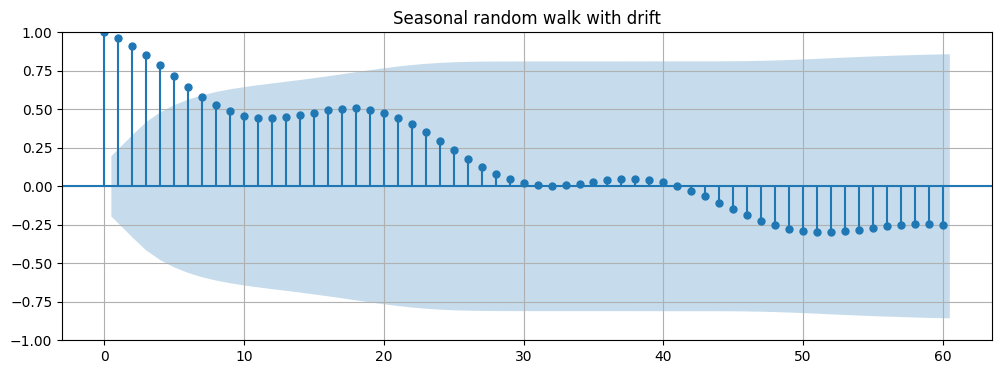

In [30]:
drift = 2
amplitude = 10
period = 20
samples = np.arange(n_steps)
seasonal = amplitude * np.sin(2 * np.pi * samples / period)

fig, [ax] = get_figure()
rw = get_random_walk(42, n_steps, variance, seasonal=seasonal, drift=drift)
sm.graphics.tsa.plot_acf(rw, lags=60, ax=ax)
ax.set_title("Seasonal random walk with drift");

## Part 3: Reimplement classical decomposition


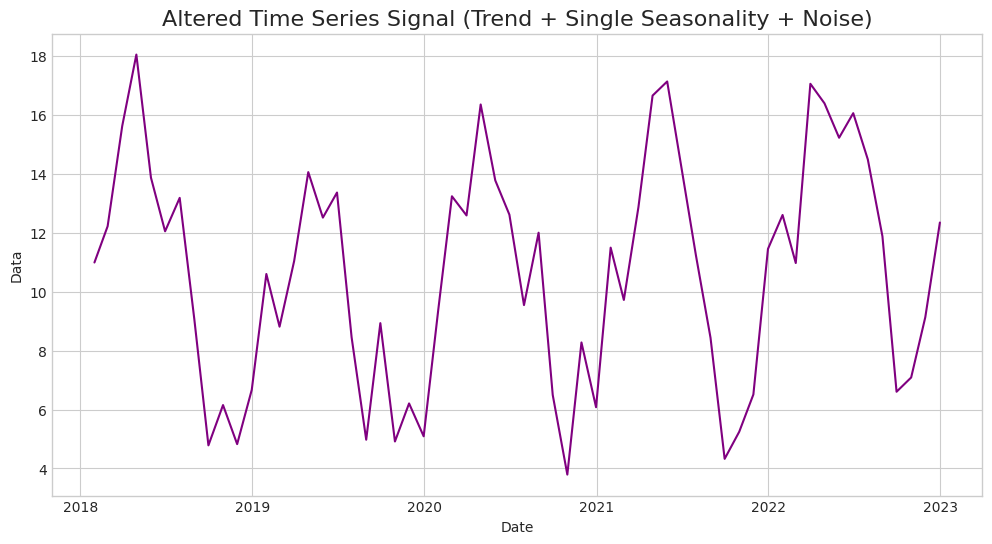

In [ ]:
np.random.seed(42)

n_periods_monthly = 12
n_years = 5
n_steps = n_periods_monthly * n_years

# Quadratic Trend
t = np.arange(n_steps)
trend = 0.05 * (t**2) / n_steps + 10

# Monthly Seasonality
monthly_seasonality = 5 * np.sin(2 * np.pi * t / n_periods_monthly)

# Noise
noise = np.random.normal(0, 2, n_steps)

# Final signal
signal = trend + monthly_seasonality + noise
df = pd.DataFrame({'Data': signal})
df.index = pd.date_range(start='2018-01-01', periods=n_steps, freq='ME')

# Plot 
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Data'], color='purple')
plt.title('Altered Time Series Signal (Trend + Seasonality + Noise)', fontsize=16)
plt.ylabel('Data')
plt.xlabel('Date')
plt.grid(True)
plt.show()

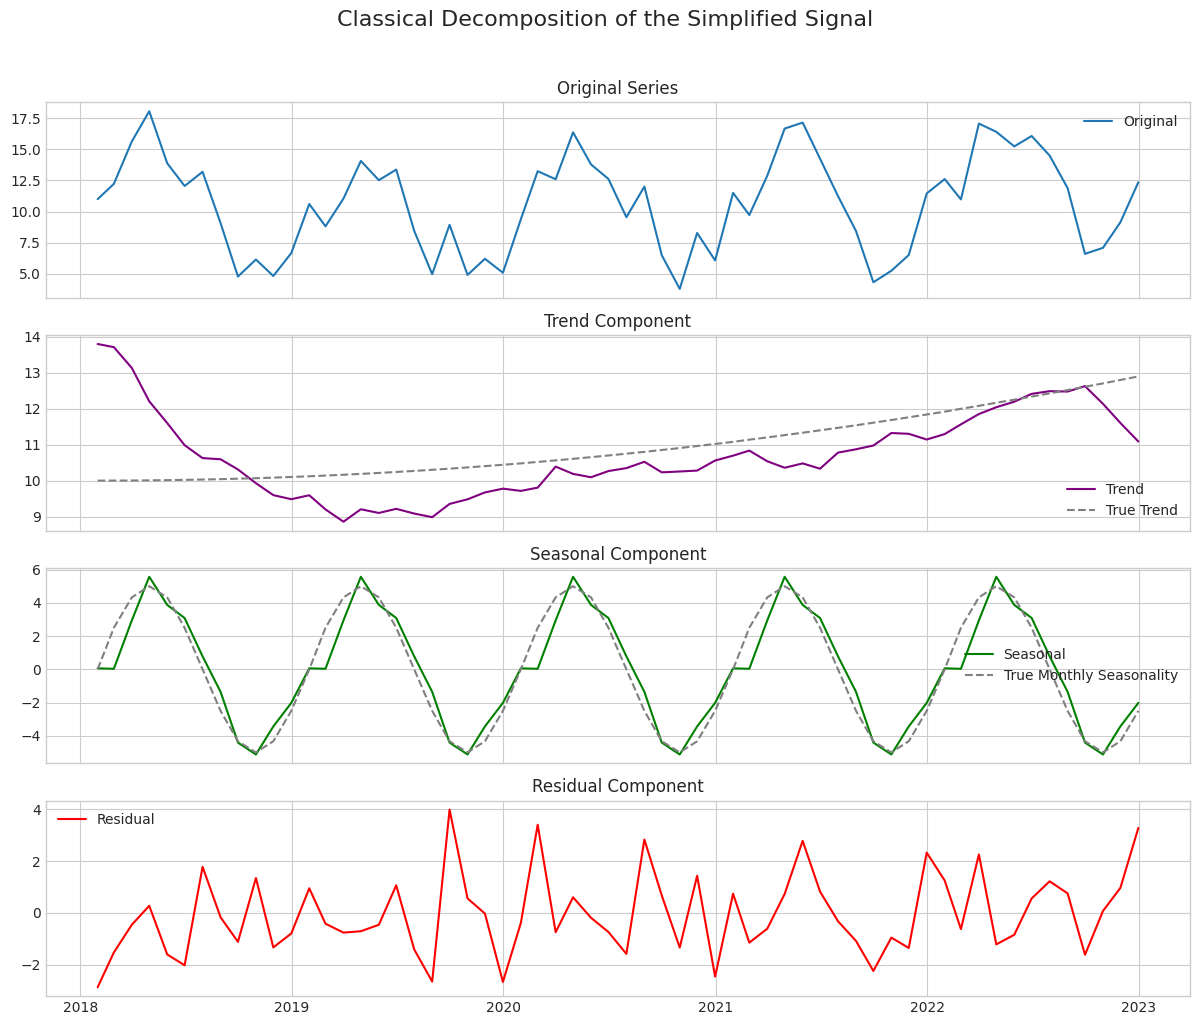

In [ ]:
# centered moving average
df['Trend'] = df['Data'].rolling(window=n_periods_monthly, center=True, min_periods=1).mean()

# Detrend
df['Detrended'] = df['Data'] - df['Trend']

# Estimate Seasonal component by averaging monthly values
df['Month'] = df.index.month
seasonal_avg = df.groupby('Month')['Detrended'].mean()
seasonal_avg_adjusted = seasonal_avg - seasonal_avg.mean()
df['Seasonal'] = df['Month'].map(seasonal_avg_adjusted)

# Residuals
df['Residual'] = df['Detrended'] - df['Seasonal']

# Plot
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)


axes[0].plot(df.index, df['Data'], label='Original')
axes[0].set_title('Original Series')
axes[0].legend()


axes[1].plot(df.index, df['Trend'], color='purple', label='Trend')
axes[1].plot(df.index, trend, color='gray', linestyle='--', label='True Trend')
axes[1].set_title('Trend Component')
axes[1].legend()

axes[2].plot(df.index, df['Seasonal'], color='green', label='Seasonal')
axes[2].plot(df.index, monthly_seasonality, color='gray', linestyle='--', label='True Monthly Seasonality')
axes[2].set_title('Seasonal Component')
axes[2].legend()

axes[3].plot(df.index, df['Residual'], color='red', label='Residual')
axes[3].set_title('Residual Component')
axes[3].legend()

plt.suptitle('Classical Decomposition of the Simplified Signal', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

## Part 3: Extend lecture 1 exercise with ACF plots and time series decomposition
Nevin